In [1]:
from mistralai import Mistral
import requests
import numpy as np
import faiss
import os
from getpass import getpass

# <font color='red'>1 - </font> Getting Data

In [2]:
path = "../dataset/data/"

In [3]:
import pandas as pd
import glob

df = pd.read_csv("../dataset/data/dataset-tickets-multi-lang3-4k.csv")

df = df.fillna('')

df.head()

,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
0,Problema crítico del servidor requiere atenció...,Es necesaria una investigación inmediata sobre...,Estamos investigando urgentemente el problema ...,Incident,Technical Support,high,es,IT Services,Urgent Issue,Service Disruption,Incident Report,Service Recovery,System Maintenance,,,,
1,Anfrage zur Verfügbarkeit des Dell XPS 13 9310,"Sehr geehrter Kundenservice,\n\nich hoffe, die...","Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Request,Customer Service,low,de,Tech Online Store,Sales Inquiry,Product Support,Customer Service,Order Issue,Returns and Exchanges,,,,
2,Erro na Autocompletação de Código do IntelliJ ...,"Prezado Suporte ao Cliente <name>,\n\nEstou es...","Prezado <name>,\n\nObrigado por entrar em cont...",Incident,Technical Support,high,pt,IT Services,Technical Support,Software Bug,Problem Resolution,Urgent Issue,IT Support,,,,
3,Urgent Assistance Required: AWS Service,"Dear IT Services Support Team, \n\nI am reachi...","Dear <name>,\n\nThank you for reaching out reg...",Request,IT Support,high,en,IT Services,IT Support,Urgent Issue,Service Notification,Cloud Services,Problem Resolution,Technical Guidance,Performance Tuning,,
4,Problème d'affichage de MacBook Air,Cher équipe de support du magasin en ligne Tec...,"Cher <name>,\n\nMerci de nous avoir contactés ...",Incident,Product Support,low,fr,Tech Online Store,Technical Support,Product Support,Hardware Failure,Service Recovery,Routine Request,,,,


In [4]:
import numpy

def format_ticket(row):
    return (
        f"SUBJECT: {row['subject']} "
        f"PROBLEM: {row['body']} "
        f"SOLUTION: {row['answer']} "
        f"PRIORITY: {row['priority']} "
        f"LANGUAGE: {row['language']} "
        f"SUPPORT TEAM: {row['queue']}"
    )

texts = df.apply(format_ticket, axis=1)
lengths = texts.str.len()
np.mean(lengths), np.max(lengths)

(1630.032, 5026)

In [5]:
texts[0]

'SUBJECT: Problema crítico del servidor requiere atención inmediata PROBLEM: Es necesaria una investigación inmediata sobre la interrupción en el servicio de gestión de AWS que está impactando funciones comerciales esenciales. SOLUTION: Estamos investigando urgentemente el problema con el servicio de gestión de AWS. Proporcionaremos actualizaciones sobre nuestro progreso. PRIORITY: high LANGUAGE: es SUPPORT TEAM: Technical Support'

In [6]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(len(df)), random_state=42)

# <font color='red'>2 - </font> Split document into chunks

In [14]:
import re

chunk_size = 2048
chunks = []

for idx in train_idx:
    text = texts[idx]
    if len(text) < 500:
        chunks.append(text)
    else:
        #using regex to cut the text into sections
        sections = re.split(r"(SUBJECT:*|PROBLEM:*|SOLUTION:*|PRIORITY:*|LANGUAGE:*|SUPPORT TEAM:*)", text)
        sections = [s.strip() for s in sections if s.strip()]
        it = iter(sections)
        sections_list = [f"{k} {v}" for k, v in zip(it, it)]

        temp_chunk = ""
        for sec in sections_list:
            #if temp_chunk + new sec is greater than the chunk size, we save the last temp chunk
            if len(temp_chunk) + len(sec) > chunk_size:
                if temp_chunk:  #no empty chunk
                    chunks.append(temp_chunk.strip())
                temp_chunk = sec
            else:
                temp_chunk += " " + sec if temp_chunk else sec
        #adding last chunk
        if temp_chunk:
            chunks.append(temp_chunk.strip())

In [15]:
len(chunks)

4025

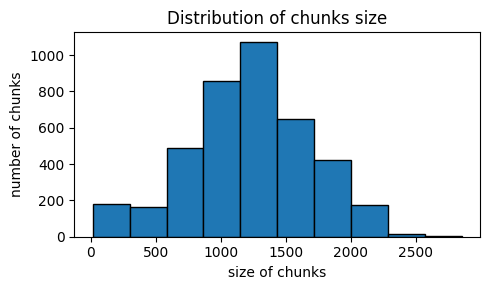

In [16]:
import matplotlib.pyplot as plt

chunks_length = [len(chunk) for chunk in chunks]
plt.figure(figsize=(5, 3))
plt.title("Distribution of chunks size")
plt.xlabel("size of chunks")
plt.ylabel("number of chunks")
plt.hist(chunks_length, bins=10, edgecolor='k')
plt.tight_layout()

# <font color='red'>3 - </font> Create embeddings for each text chunk

In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
embeddings = model.encode(chunks)

# <font color='red'>4 - </font> Load into a vector database

In [19]:
import faiss

d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

# <font color='red'>5 - </font> Create embeddings for a ticket

In [36]:
ticket_sample

"SUBJECT:  PROBLEM: Cher service client,\n\nJ'espère que ce message vous trouve en bonne santé. Je vous écris pour demander une mise à niveau de nos licences Google Workspace pour l'équipe de vente afin d'améliorer leur productivité et leurs capacités de collaboration. Actuellement, nous utilisons l'édition Business Standard, et une transition vers un plan plus avancé serait très bénéfique pour notre équipe. Veuillez nous faire savoir les procédures et les coûts associés à cette mise à niveau.\n\nMerci pour votre assistance.\n\nCordialement,\n\n<name> SOLUTION: Cher <name>,\n\nMerci de nous avoir contactés concernant la mise à niveau de vos licences Google Workspace. Pour passer de Business Standard à un plan plus avancé, vous pouvez envisager des options telles que Business Plus, Enterprise Standard ou Enterprise Plus. Ces plans offrent des fonctionnalités améliorées pour la collaboration et la productivité.\n\nPour procéder à la mise à niveau, vous pouvez accéder à la console d'admin

In [65]:
ticket_sample = texts[test_idx[471]]
ticket_sample_problem = re.search(r"PROBLEM:(.*?)(?=SUBJECT:|SOLUTION:|PRIORITY:|LANGUAGE:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()
ticket_sample_answer = re.search(r"SOLUTION:(.*?)(?=SUBJECT:|SOLUTION:|PRIORITY:|LANGUAGE:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()
print(ticket_sample_problem)
ticket_sample_embeddings = model.encode(ticket_sample).reshape(1, -1)

Ich benötige Hilfe, um den Druck über meinen Canon-Drucker einzurichten.


# <font color='red'>6 - </font> Retrieve similar chunks from the vector database

In [66]:
D, I = index.search(ticket_sample_embeddings, k=3)
retrieved_chunk = [chunks[i] for i in I.tolist()[0]]
retrieved_chunk

['SUBJECT: Preciso de ajuda para configurar a impressora Canon PROBLEM: Caro time de suporte da Tech Online Store,\n\nPreciso de assistência para configurar as capacidades de impressão sem fio e móvel da minha impressora Canon PIXMA MG3620. Enfrentei algumas dificuldades ao tentar estabelecer a conectividade sem fio e garantir que funcione sem problemas com meus dispositivos móveis. Agradeceria imensamente qualquer sugestão de aconselhamento ou resolução de problemas que você pudesse oferecer para me ajudar a corrigir esse problema. Orientações detalhadas sobre como configurar corretamente esses recursos seriam extremamente úteis. Se necessário, estou aberto a uma ligação telefônica ou a instruções adicionais.\n\nPor favor, informe-me como podemos lidar de forma eficaz com esta situação. Aguardo sua resposta rápida e agradeço antecipadamente pela sua ajuda.\n\nAtenciosamente,\n\n<name>',
 'SUBJECT: Hilfe bei der Einrichtung des drahtlosen Druckers PROBLEM: Sehr geehrter Kundenservice d

# <font color='red'>7 - </font> Combine context and question in a prompt and generate response

In [67]:
prompt = f"""
Context information is below.
---------------------
{retrieved_chunk}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {ticket_sample_problem}
"""

In [ ]:
import os
from mistralai import Mistral

api_key = os.environ["MISTRAL_API_KEY"]

client = Mistral(api_key=api_key)

In [69]:
def run_mistral(user_message, model="mistral-small-2506"):
    messages = [
        {
            "role": "user", "content": user_message
        }
    ]
    chat_response = client.chat.complete(
        model=model,
        messages=messages
    )
    return (chat_response.choices[0].message.content)

responses = run_mistral(prompt)

In [70]:
print(responses)

Hier sind einige Schritte, die Ihnen helfen können, den Druck über Ihren Canon-Drucker einzurichten:

1. **Stellen Sie sicher, dass Ihr Drucker und Router in Reichweite sind** und keine Hindernisse die Verbindung stören.
2. **Überprüfen Sie die WLAN-Anzeige am Drucker**: Falls sie nicht blau blinkt, drücken und halten Sie die Wi-Fi-Taste, bis sie blinkt, und drücken Sie dann die WPS-Taste an Ihrem Router.
3. **Aktualisieren Sie die Firmware Ihres Druckers** auf der offiziellen Canon-Website.
4. **Starten Sie Ihren Drucker und WLAN-Router neu**, um mögliche Verbindungsprobleme zu beheben.
5. **Verwenden Sie die Canon PRINT-App** auf Ihrem Smartphone oder Tablet, um den Drucker einzurichten.

Falls diese Schritte nicht funktionieren, können Sie uns gerne für weitere Unterstützung kontaktieren.

Mit freundlichen Grüßen,
Tech Online Store Support


In [71]:
print(ticket_sample_answer)

Bitte stellen Sie sicher, dass die App installiert ist, verbinden Sie sich mit dem WLAN, wählen Sie den Drucker in den Einstellungen aus und drucken Sie.


In [74]:
from sklearn.metrics.pairwise import cosine_similarity

encoded_response = model.encode(responses)
true_encoded_response = model.encode(ticket_sample_answer)

cosine_similarity([encoded_response], [true_encoded_response])

array([[0.64658844]], dtype=float32)